In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

import contextily as ctx

import time
from tqdm import tqdm

# from multiprocessing import Pool

In [79]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [80]:
pool = mp.Pool(mp.cpu_count())

In [3]:
msoa_cropped = gpd.read_file('../data/output.msoa_cropped.geojson')
msoa_cropped['area'] = msoa_cropped['geometry'].area

In [3]:
msoa_cropped.shape

(154, 5)

In [4]:
msoa_id = []
convexes = []

for i in range(msoa_cropped.shape[0]):
    msoa_id.append(msoa_cropped.iloc[[i]]['MSOA11CD'].values[0])
    buf = msoa_cropped.iloc[[i]].buffer(300)
    buf_gdf = gpd.GeoDataFrame(geometry=buf, crs='epsg:27700')
    buf_gdf = buf_gdf.to_crs('epsg:4326')
    c = buf_gdf['geometry'].unary_union.convex_hull
    convexes.append(c)

In [99]:
convexes_list = list(zip(msoa_id,convexes))

In [101]:
len(convexes_list)

154

In [76]:
msoa_to_network = pd.DataFrame()

for i in tqdm(range(len(convexes_list))):
    G = ox.graph_from_polygon(convexes_list[i][1], network_type='walk', simplify=True)
    G = ox.project_graph(G,to_crs='EPSG:27700')
    G2 = ox.utils_graph.get_digraph(G, weight='length')
    G_un = G2.to_undirected()
    ebc = nx.edge_betweenness_centrality(G_un, weight="length", normalized=False)
    nx.set_edge_attributes(G_un, ebc, "ebc")
    G3 = nx.MultiGraph(G_un)
    ox.save_graph_shapefile(G3, '../data/graphs/g' + str(convexes_list[i][0]))
    
    edges_gdf = ox.graph_to_gdfs(G3, nodes=False).reset_index()
    edges_gdf = edges_gdf[['osmid', 'name', 'length', 'geometry', 'ebc']]

    edges_to_msoa = gpd.sjoin(edges_gdf, msoa_cropped, how="inner", op="intersects")
    edges_to_msoa = edges_to_msoa[edges_to_msoa.MSOA11CD==convexes_list[i][0]]

    msoa_network_item = edges_to_msoa.groupby(['MSOA11CD']
                                          ).aggregate({'length':'sum', 'ebc':'median', 'area':'mean'}).reset_index()
    msoa_network_item.columns = ['MSOA11CD', 'street_length','median_ebc', 'msoa_area']
    msoa_network_item['street_density'] = msoa_network_item['street_length']/msoa_network['msoa_area']
    msoa_to_network = msoa_to_network.append(msoa_network_item)

  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

0
0
0


/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1/2 [05:37<05:37, 337.73s/it]

1
1
1


/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:03<00:00, 181.53s/it]


In [77]:
msoa_to_network

,MSOA11CD,street_length,median_ebc,msoa_area,street_density
0,E02000001,140254.538,34574.0,2.905399e+06,0.048274
0,E02000180,13919.782,4252.0,4.856208e+05,0.004791


In [102]:
msoa_to_network = pd.DataFrame()

In [103]:
def get_network_info(convexes_list):
    msoa_to_network = pd.DataFrame()
    for i in tqdm(range(len(convexes_list))):
        G = ox.graph_from_polygon(convexes_list[i][1], network_type='walk', simplify=True)
        G = ox.project_graph(G,to_crs='EPSG:27700')
        G2 = ox.utils_graph.get_digraph(G, weight='length')
        G_un = G2.to_undirected()
        ebc = nx.edge_betweenness_centrality(G_un, weight="length", normalized=False)
        nx.set_edge_attributes(G_un, ebc, "ebc")
        G3 = nx.MultiGraph(G_un)
        ox.save_graph_shapefile(G3, '../data/graphs/g' + str(convexes_list[i][0]))

        edges_gdf = ox.graph_to_gdfs(G3, nodes=False).reset_index()
        edges_gdf = edges_gdf[['osmid', 'name', 'length', 'geometry', 'ebc']]

        edges_to_msoa = gpd.sjoin(edges_gdf, msoa_cropped, how="inner", op="intersects")
        edges_to_msoa = edges_to_msoa[edges_to_msoa.MSOA11CD==convexes_list[i][0]]

        msoa_network_item = edges_to_msoa.groupby(['MSOA11CD']
                                              ).aggregate({'length':'sum', 'ebc':'median', 'area':'mean'}).reset_index()
        msoa_network_item.columns = ['MSOA11CD', 'street_length','median_ebc', 'msoa_area']
        msoa_network_item['street_density'] = msoa_network_item['street_length']/msoa_network['msoa_area']
        msoa_to_network = msoa_to_network.append(msoa_network_item)
    return msoa_to_network

In [104]:
start = time.time()
print(start)

msoa_to_network = get_network_info(convexes_list)
msoa_to_network.to_csv('../data/x/msoa_to_network.csv', index=False)

end = time.time()
print(f"Total time: {end - start} seconds")
print(f"Total time: {round((end - start)/60)} mins")

1629937316.4131372


  0%|                                                                                                                                                       | 0/154 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
  1%|▉                                                                                                                                          | 1/154 [05:59<15:16:37, 359.46s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
  1%|█▊                                                                                                                                         

 25%|██████████████████████████████████▌                                                                                                         | 38/154 [29:43<1:17:56, 40.31s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 25%|███████████████████████████████████▍                                                                                                        | 39/154 [31:00<1:38:11, 51.23s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 26%|████████████████████████████████████▎                                                                                                      

 49%|██████████████████████████████████████████████████████████████████████                                                                        | 76/154 [56:56<33:57, 26.12s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 77/154 [1:01:48<2:16:09, 106.09s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 51%|█████████████████████████████████████████████████████████████████████▉                                                                    |

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 114/154 [1:27:40<35:58, 53.95s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 115/154 [1:27:57<27:46, 42.73s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 152/154 [1:53:29<01:27, 43.98s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 153/154 [1:53:51<00:37, 37.22s/it]/opt/conda/lib/python3.7/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Total time: 6908.876164197922 seconds
Total time: 115 mins


In [105]:
msoa_to_network

,MSOA11CD,street_length,median_ebc,msoa_area,street_density
0,E02000001,140254.538,34574.0,2.905399e+06,0.048274
0,E02000180,13919.782,4252.0,4.856208e+05,0.004791
0,E02000183,25426.076,4194.5,7.691398e+05,0.008751
0,E02000184,19658.594,4947.0,6.660963e+05,0.006766
0,E02000186,27018.660,10242.0,1.001597e+06,0.009299
...,...,...,...,...,...
0,E02000983,16018.581,2655.0,3.743863e+05,0.005513
0,E02006801,43037.828,8358.5,1.138729e+06,0.014813
0,E02006802,25490.767,10476.0,6.911753e+05,0.008774
0,E02006853,12149.903,2706.0,5.009082e+05,0.004182


In [97]:
# start = time.time()

# pool = mp.Pool(mp.cpu_count())

# msoa_to_network2 = pool.map(get_network_info, convexes_list)

# pool.close()

# end = time.time()
# print(f"Total time: {end - start} seconds")

  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'is_valid'

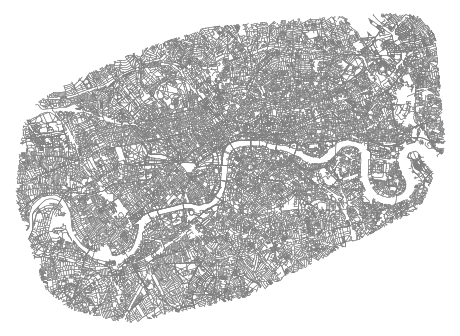

In [7]:
G = ox.graph_from_polygon(c, network_type='walk', simplify=True)
G = ox.project_graph(G,to_crs='EPSG:27700')
ox.plot_graph(G, bgcolor = 'w', edge_linewidth=0.5, edge_color ='grey', node_size=0);

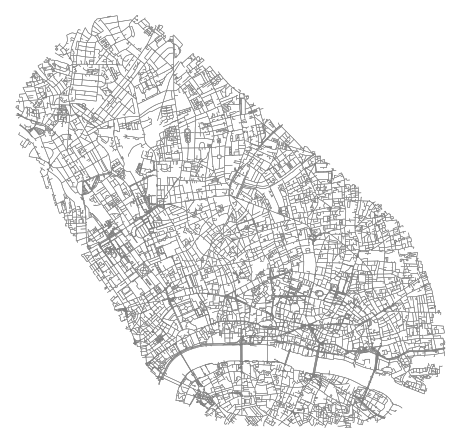

In [21]:
G = ox.graph_from_polygon(c, network_type='walk', simplify=True)
G = ox.project_graph(G,to_crs='EPSG:27700')
ox.plot_graph(G, bgcolor = 'w', edge_linewidth=0.5, edge_color ='grey', node_size=0);

In [6]:
# ox.save_graph_shapefile(G_proj, '../data/msoa_graph')

### Centrality measures

In [ ]:
pool = 2

In [ ]:
def calculate_ebc(g):
    ebc = nx.edge_betweenness_centrality(g, weight="length", normalized=False)
    nx.set_edge_attributes(g, ebc, "ebc")
    ox.save_graph_shapefile(g, '../data/graphs' + str(g))
    edges_gdf = ox.graph_to_gdfs(g, nodes=False).reset_index()
    edges_gdf = edges_gdf[['osmid', 'name', 'length', 'geometry', 'ebc']]
    return g

In [63]:
msoa_network = edges_to_msoa.groupby(['MSOA11CD']
                                          ).aggregate({'length':'sum', 'ebc':'median', 'area':'mean'}).reset_index()
msoa_network.columns = ['MSOA11CD', 'street_length','median_ebc', 'msoa_area']
msoa_network['street_density'] = msoa_network['street_length']/msoa_network['msoa_area']

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

msoa_cropped.plot(ax=ax, alpha=0.5, color='grey')
edges_gdf.plot(ax=ax, alpha=0.4, color='grey');
edges_to_msoa.plot(ax=ax, column='ebc', cmap='plasma')
ax.set_axis_off()
# fig.savefig('../export/2msoa_connectivity')

*'street density is the linear sum of all edges in the undirected representation of the graph divided by the area'*  
https://arxiv.org/pdf/1708.00845.pdf  
p72

In [ ]:
msoa_network_un = edges_un_to_msoa.groupby(['MSOA11CD']
                                          ).aggregate({'length':'sum', 'ebc':'median', 'area':'mode'}).reset_index()
msoa_network.columns = ['MSOA11CD', 'total_length','median_ebc', 'area']
msoa_network['street_density'] = msoa_network['total_length']/msoa_network['area']